# Statistical Arbitrage with Vine Copulas (March application)
Structure:
- Abstract
- Introduction
- Body
- Conclusion
- Learnings

## Abstract
The paper [Statistical Arbitrage with Vine Copulas [Stübinger, Mangold, Krauss (2016)]](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf) presents the use of vine copulas for statistical arbitrage. First the three most suitable partner stocks for a target stock get selected. Second a distribution function is fitted to the top 20 pairs. Third, the best copula is chosen by fitting them to the transformed returns. Fourth conditional distributions are derived and later transformed to daily mispricings. 

## Introduction
Pairs trading with statistical arbitrage is a popular research topic for quants since the beginning of algorithmic trading. 
This notebook focuses on the partner selection process of section 3.1 of the mentioned paper.
The idea is to present a functional module for partner selection:
First the module for the partner selection will be imported. The framework is then used to build partners from historic SP500 data. Performance is evaluated.
Basic functionality is presented with examples.
The Python module *vinecopulaslab* provides both a stock ticker and a partner selection framework.

## Body


### The framework
*vinecopulaslab* can simply be imported with:

*import vinecopulaslab as vl*

Or you can import the submodules directly. The framework is presented alongside code. Let's fetch the historic SP500 closing data. It usually takes around one minute. Luckily the request is getting cached.

### The UniverseDownloader class

In [2]:
%load_ext autoreload
%autoreload 2

from vinecopulaslab.universe import UniverseDownloader
from vinecopulaslab.partnerselection import TraditionalSelection, ExtendedSelection, GeometricSelection, ExtremalSelection

import seaborn as sns
sns.set()

sp500_prices = UniverseDownloader(cache=True).historic_sp500_prices(start='2017-01-01',
                                                       end='2018-01-01')
sp500_prices.head(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


A        AAL         AAP       AAPL       ABBV        ABC  \
Date                                                                            
2017-01-03  46.490002  46.299999  170.600006  29.037500  62.410000  82.610001   
2017-01-04  47.099998  46.700001  172.000000  29.004999  63.290001  84.660004   

                  ABMD        ABT         ACN        ADBE  ...       XLNX  \
Date                                                       ...              
2017-01-03  112.360001  39.049999  116.459999  103.480003  ...  59.070000   
2017-01-04  115.739998  39.360001  116.739998  104.139999  ...  58.639999   

                  XOM       XRAY        XRX        XYL        YUM         ZBH  \
Date                                                                            
2017-01-03  90.889999  58.619999  27.559999  49.650002  63.209999  103.330002   
2017-01-04  89.889999  59.099998  28.600000  50.389999  63.439999  104.279999   

                 ZBRA       ZION        ZTS  
Date                                         
2017-01-03  86.250000  43.180000  53.590000  
2017-01-04  87.029999  43.799999  54.110001  

[2 rows x 505 columns]

## Approaches from the paper
The paper compares four different selection approaches. Each selection approach will be implemented in a class
#### The TraditionalSelection class

The TraditionalSelection is based on the subsection of the paper 3.1.1.. It is based on calculating the Spearmann correlation for the daily stock returns. Then the top 50 correlated stocks are filtered for a target stock to reduce the search space. Finally, it calculates the sum of the Spearman correlation for all possible quadruples of a target stock and picks the highest score.


Finding all quadruples for all the stocks in the SP500:

In [9]:
%%time
partners = TraditionalSelection().find_partners(sp500_prices)

CPU times: user 3min 37s, sys: 2min 29s, total: 6min 7s
Wall time: 6min 6s


In [7]:
partners.head(10)

TARGET_STOCK
A              [A, WAT, PKI, TMO]
AAL          [AAL, LUV, DAL, UAL]
AAP         [AAP, GPC, AZO, ORLY]
AAPL    [AAPL, AMZN, GOOGL, GOOG]
ABBV          [ABBV, PKI, A, TMO]
ABC         [ABC, HSIC, MCK, CAH]
ABMD          [ABMD, A, TMO, PKI]
ABT            [ABT, PKI, A, TMO]
ACN            [ACN, V, MA, MSFT]
ADBE          [ADBE, MA, V, MSFT]
dtype: object

### Features
- Vectorization
- Selecting a subset of target stocks

In [18]:
%%time
TraditionalSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.41 s, sys: 350 ms, total: 1.76 s
Wall time: 1.73 s


TARGET_STOCK
MSFT    [MSFT, AMZN, GOOGL, GOOG]
dtype: object

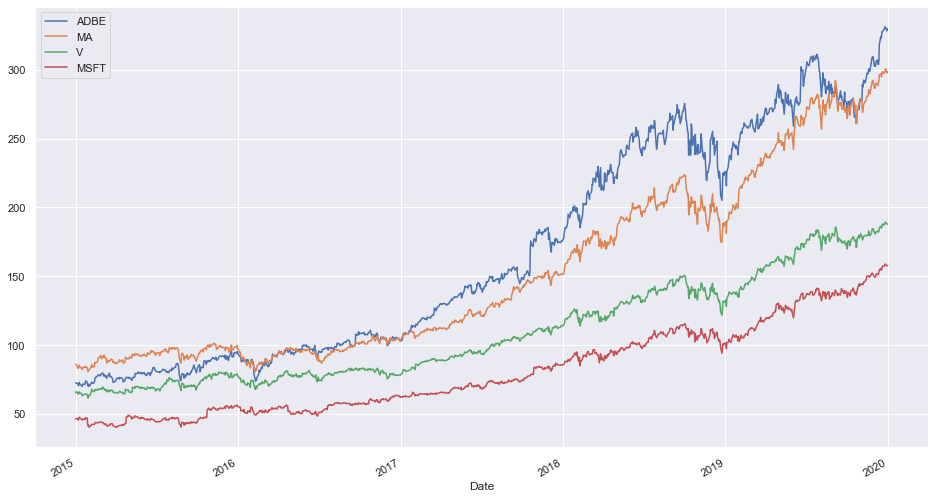

In [8]:
sample_partners = partners["ADBE"]
sp500_prices[sample_partners].plot(figsize=(16,9));

#### The ExtendedSelection class

The ExtendedSelection is extending the Spearman correlation by using the mean of three estimators. It is based on  Schmid, F., Schmidt, R., 2007. Multivariate extensions of Spearman’s rho and related statistics. Statistics & Probability Letters 77 (4), 407–416.

In [48]:
%%time
partners_e = ExtendedSelection().find_partners(sp500_prices)

CPU times: user 17min 27s, sys: 16min 33s, total: 34min 1s
Wall time: 34min 27s


In [51]:
partners_e.head(10)

TARGET_STOCK
A              [A, WAT, PKI, TMO]
AAL          [AAL, LUV, DAL, UAL]
AAP         [AAP, GPC, AZO, ORLY]
AAPL    [AAPL, AMZN, GOOGL, GOOG]
ABBV          [ABBV, PKI, A, TMO]
ABC         [ABC, HSIC, MCK, CAH]
ABMD          [ABMD, A, TMO, PKI]
ABT            [ABT, PKI, A, TMO]
ACN            [ACN, V, MA, MSFT]
ADBE          [ADBE, MA, V, MSFT]
dtype: object

In [24]:
%%time
ExtendedSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.62 s, sys: 461 ms, total: 2.08 s
Wall time: 2.08 s


TARGET_STOCK
MSFT    [MSFT, AMZN, GOOGL, GOOG]
dtype: object

#### The GeometricSelection class

The GeometricSelection is transforming the prices to ranked returns and uses their percentile to create 4d space and measure the distance to hyperdimensional diagonal. A small example chart will follow

In [252]:
%%time
partners_g = GeometricSelection().find_partners(sp500_prices)

CPU times: user 1min 30s, sys: 39.4 s, total: 2min 10s
Wall time: 2min 11s


In [7]:
%%time
GeometricSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.25 s, sys: 164 ms, total: 1.42 s
Wall time: 1.41 s


TARGET_STOCK
MSFT    [MSFT, FB, GOOGL, GOOG]
dtype: object

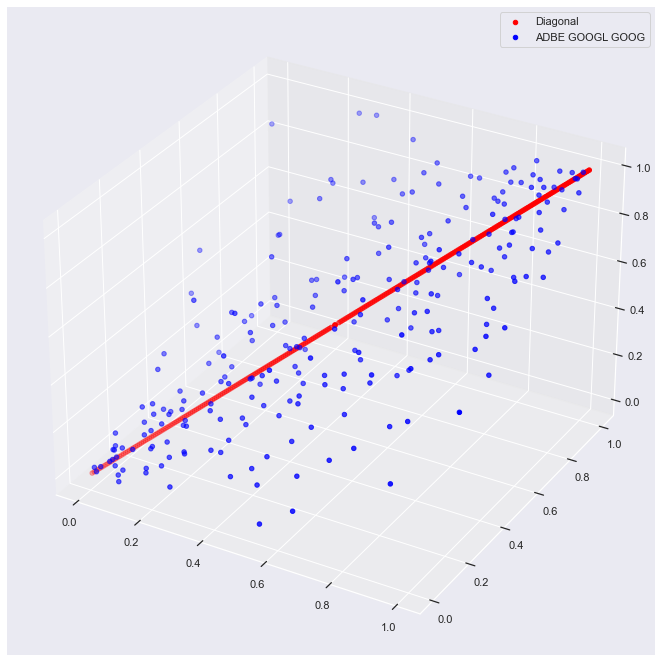

In [268]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
sample = sp500_prices[sample_partners[:3]].pct_change(fill_method='ffill').dropna(how='all')
values = sample.rank(pct=True).values
y = np.linspace(0,1)
x = np.linspace(0,1)
z = np.linspace(0,1)
ax.scatter(values[:,0],values[:,0],values[:,0], label="Diagonal",c="red")  
ax.scatter(values[:,0],values[:,1],values[:,2], label=" ".join(sample_partners[:3]),c="blue")  
ax.legend();

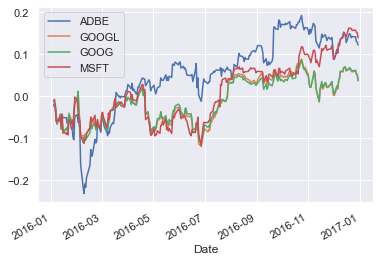

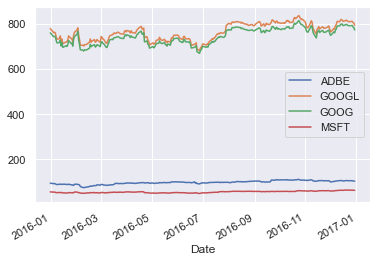

In [257]:
sample_partners = partners_g.tolist()[9]
sp500_prices[sample_partners].pct_change(fill_method='ffill').dropna(how='all').cumsum(axis=0).plot();
sp500_prices[sample_partners].plot();

In [45]:
from vinecopulaslab.partnerselection import ExtremalSelection

## Extremal Selection (status: not complete)
Currently, the extremal selection approach is not fully implemented. It was hacked together in an effort make it vectorized. It is purely presented to research performance.

In [3]:
EX = ExtremalSelection()

In [52]:
%%time
partners_e = EX.find_partners(sp500_prices)

CPU times: user 1h 26min 20s, sys: 30min 32s, total: 1h 56min 53s
Wall time: 1h 4min 27s


In [8]:
%%time
EX.find_partners(sp500_prices, ["MSFT"])

CPU times: user 12.5 s, sys: 5.25 s, total: 17.7 s
Wall time: 11.2 s


TARGET_STOCK
MSFT    [MSFT, FB, GOOGL, GOOG]
dtype: object

In [7]:
%%time
EX.find_partners(sp500_prices, ["MSFT", "BAC", "TMO"])

CPU times: user 34.6 s, sys: 15.1 s, total: 49.7 s
Wall time: 30.6 s


TARGET_STOCK
BAC      [BAC, FITB, HBAN, JPM]
MSFT    [MSFT, FB, GOOGL, GOOG]
TMO          [TMO, DHR, PKI, A]
dtype: object

### Performance
For performance purposes it was tried as much as possible to use vectorized calculations.
For example the traditional approach took 30 seconds with only for loops for one target stock.
Later it got down to 2 seconds using the least for loops as possible.
This brings amazing result.

## Conclusion
The paper compares 4 different approaches to partner selections. The implementation for this project was mainly done in pure numpy and pandas. The main goal is to build a framework for partner selection. This is not fully completed yet. In the implementation it was mainly optimized for vectorized operation so no for-loops. For future research speed could further be improved with numba.

### Learnings
- Speed vs readability
- Implementing a simple prototype and then making it more complex
- Learning about copulas and their use in finance
- Start with a clean implementation instead of hacking things together.

Thanks for your attention,
Franz Krekeler